
4. Siamese Networks
Contrastive Loss를 사용하는 네트워크에 대해 알려줘


PCA

---
# 0. 데이터 정의하기

recall 평가지표, 필요한 라이브러리 불러오기

In [ ]:
def recall5(answer_df, submission_df):
    """
    Calculate recall@5 for given dataframes.

    Parameters:
    - answer_df: DataFrame containing the ground truth
    - submission_df: DataFrame containing the predictions

    Returns:
    - recall: Recall@5 value
    """

    primary_col = answer_df.columns[0]
    secondary_col = answer_df.columns[1]

    # Check if each primary_col entry has exactly 5 secondary_col predictions
    prediction_counts = submission_df.groupby(primary_col).size()
    if not all(prediction_counts == 5):
        raise ValueError(f"Each {primary_col} should have exactly 5 {secondary_col} predictions.")


    # Check for NULL values in the predicted secondary_col
    if submission_df[secondary_col].isnull().any():
        raise ValueError(f"Predicted {secondary_col} contains NULL values.")

    # Check for duplicates in the predicted secondary_col for each primary_col
    duplicated_preds = submission_df.groupby(primary_col).apply(lambda x: x[secondary_col].duplicated().any())
    if duplicated_preds.any():
        raise ValueError(f"Predicted {secondary_col} contains duplicates for some {primary_col}.")


    # Filter the submission dataframe based on the primary_col present in the answer dataframe
    submission_df = submission_df[submission_df[primary_col].isin(answer_df[primary_col])]

    # For each primary_col, get the top 5 predicted secondary_col values
    top_5_preds = submission_df.groupby(primary_col).apply(lambda x: x[secondary_col].head(5).tolist()).to_dict()

    # Convert the answer_df to a dictionary for easier lookup
    true_dict = answer_df.groupby(primary_col).apply(lambda x: x[secondary_col].tolist()).to_dict()


    individual_recalls = []
    for key, val in true_dict.items():
        if key in top_5_preds:
            correct_matches = len(set(true_dict[key]) & set(top_5_preds[key]))
            individual_recall = correct_matches / min(len(val), 5) # 공정한 평가를 가능하게 위하여 분모(k)를 'min(len(val), 5)' 로 설정함
            individual_recalls.append(individual_recall)


    recall = np.mean(individual_recalls)
    return recall

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from collections import defaultdict

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_distances

훈련 데이터 - 검증데이터 분류하기

In [ ]:
apply_train = pd.read_csv('./apply_train.csv')

#학습, 검증 분리
train, val = [], []
apply_train_groupby = apply_train.groupby('resume_seq')['recruitment_seq'].apply(list)
for uid, iids in zip(apply_train_groupby.index.tolist(), apply_train_groupby.values.tolist()):
    for iid in iids[:-1]:
        train.append([uid,iid])
    val.append([uid, iids[-1]])

# 학습데이터
train = pd.DataFrame(train, columns=['resume_seq', 'recruitment_seq'])
# 검증데이터
val = pd.DataFrame(val, columns=['resume_seq', 'recruitment_seq'])
pred = apply_train.copy()

# 분리한 학습데이터와 검증데이터로 '사용자 기반' 행렬과 '아이템 기반' 행렬 생성하기
train_user_item_matrix = train.groupby(['resume_seq', 'recruitment_seq']).size().unstack(fill_value=0)
train_item_user_matrix = train.groupby(['recruitment_seq','resume_seq']).size().unstack(fill_value=0)
pred_user_item_matrix = pred.groupby(['resume_seq', 'recruitment_seq']).size().unstack(fill_value=0)
pred_item_user_matrix = pred.groupby(['recruitment_seq','resume_seq']).size().unstack(fill_value=0)


---
# 1. 유사도 다양하게 적용해보기
> [채택] 자카드 유사도  
> [채택] 코사인 유사도  
> 햄밍 유사도  
> 유클리디안 유사도  
> [채택] 피어슨 유사도  

`최고의 조합` : "only 피어슨 유사도"

### `자카드 유사도`에 기반한 추천 점수를 계산한다.

In [ ]:
# 사용자 간의 자카드 유사성 계산
train_user_jaccard_distances = pairwise_distances(train_user_item_matrix.values, metric='jaccard')
train_user_jaccard_similarity = 1 - train_user_jaccard_distances
train_item_jaccard_distances = pairwise_distances(train_item_user_matrix.values, metric='jaccard')
train_item_jaccard_similarity = 1 - train_item_jaccard_distances
pred_user_jaccard_distances = pairwise_distances(pred_user_item_matrix.values, metric='jaccard')
pred_user_jaccard_similarity = 1 - pred_user_jaccard_distances
pred_item_jaccard_distances = pairwise_distances(pred_item_user_matrix.values, metric='jaccard')
pred_item_jaccard_similarity = 1 - pred_item_jaccard_distances

# 추천 점수 계산
train_user_predicted_scores_jaccard = train_user_jaccard_similarity.dot(train_user_item_matrix)
train_item_predicted_scores_jaccard = train_item_jaccard_similarity.dot(train_item_user_matrix)
pred_user_predicted_scores_jaccard = pred_user_jaccard_similarity.dot(pred_user_item_matrix)
pred_item_predicted_scores_jaccard = pred_item_jaccard_similarity.dot(pred_item_user_matrix)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [ ]:
train_item_predicted_scores = train_item_predicted_scores_jaccard
train_user_predicted_scores = train_user_predicted_scores_jaccard

item_weight = 0.7

train_recommendations = []
for idx, user in tqdm(enumerate(train_user_item_matrix.index)):
    applied_jobs = set(train_user_item_matrix.loc[user][train_user_item_matrix.loc[user] == 1].index)

    # 해당 사용자의 추천 점수 (높은 점수부터 정렬)
    sorted_job_indices = (train_item_predicted_scores[:,idx] * item_weight + train_user_predicted_scores[idx]).argsort()[::-1]
    recommended_jobs = [job for job in train_user_item_matrix.columns[sorted_job_indices] if job not in applied_jobs][:5]

    for job in recommended_jobs:
        train_recommendations.append([user, job])
top_recommendations = pd.DataFrame(train_recommendations, columns=['resume_seq', 'recruitment_seq'])
val_prediction = pd.DataFrame(train_recommendations, columns=['resume_seq', 'recruitment_seq'])

0it [00:00, ?it/s]

In [ ]:
recall5(val,val_prediction) # 0.8

0.12497052581938223

In [ ]:
recall5(val,val_prediction) #  0.7 # 0.65

0.12497052581938223

### `코사인 유사도`에 기반한 추천 점수를 계산한다.

In [ ]:
# 사용자 간의 cosine 유사성 계산
train_user_cos_similarity = cosine_similarity(train_user_item_matrix)
train_item_cos_similarity = cosine_similarity(train_item_user_matrix)
pred_user_cos_similarity = cosine_similarity(pred_user_item_matrix)
pred_item_cos_similarity = cosine_similarity(pred_item_user_matrix)

# 추천 점수 계산
train_user_predicted_scores_cos = train_user_cos_similarity.dot(train_user_item_matrix)
train_item_predicted_scores_cos = train_item_cos_similarity.dot(train_item_user_matrix)
pred_user_predicted_scores_cos = pred_user_cos_similarity.dot(pred_user_item_matrix)
pred_item_predicted_scores_cos = pred_item_cos_similarity.dot(pred_item_user_matrix)

In [ ]:
train_item_predicted_scores = train_item_predicted_scores_cos
train_user_predicted_scores = train_user_predicted_scores_cos

item_weight = 1

train_recommendations = []
for idx, user in tqdm(enumerate(train_user_item_matrix.index)):
    applied_jobs = set(train_user_item_matrix.loc[user][train_user_item_matrix.loc[user] == 1].index)

    # 해당 사용자의 추천 점수 (높은 점수부터 정렬)
    sorted_job_indices = (train_item_predicted_scores[:,idx] * item_weight + train_user_predicted_scores[idx]).argsort()[::-1]
    recommended_jobs = [job for job in train_user_item_matrix.columns[sorted_job_indices] if job not in applied_jobs][:5]

    for job in recommended_jobs:
        train_recommendations.append([user, job])
top_recommendations = pd.DataFrame(train_recommendations, columns=['resume_seq', 'recruitment_seq'])
val_prediction = pd.DataFrame(train_recommendations, columns=['resume_seq', 'recruitment_seq'])

0it [00:00, ?it/s]

In [ ]:
recall5(val,val_prediction) # test

0.12874322093845791

In [ ]:
recall5(val,val_prediction) # test   1

0.12874322093845791

### [drop] `햄밍 거리`에 기반한 추천 점수를 계산한다.
* 각 구직자가 지원한 채용 공고의 패턴이 얼마나 다른지를 비교할 때 유용합니다. 지원 여부가 다른 지점의 수를 계산
* 햄밍 거리는 주로 이진 데이터에 사용되며, 사용자들이 아이템에 대해 "지원/미지원"과 같은 이진 결정을 내릴 때 유용

In [ ]:
# 사용자 간의 햄밍거리 유사성 계산
train_user_hamming_distances = pairwise_distances(train_user_item_matrix.values, metric='hamming')
train_item_hamming_distances = pairwise_distances(train_item_user_matrix.values, metric='hamming')

train_user_hamming_similarity = 1 - train_user_hamming_distances
train_item_hamming_similarity = 1 - train_item_hamming_distances

# 추천 점수 계산
train_user_predicted_scores_hamming = train_user_hamming_similarity.dot(train_user_item_matrix) / np.array([np.abs(train_user_hamming_similarity).sum(axis=1)]).T
train_item_predicted_scores_hamming = train_item_hamming_similarity.dot(train_item_user_matrix) / np.array([np.abs(train_item_hamming_similarity).sum(axis=1)]).T

In [ ]:
train_item_predicted_scores = train_item_predicted_scores_hamming
train_user_predicted_scores = train_user_predicted_scores_hamming

item_weight = 1

train_recommendations = []
for idx, user in tqdm(enumerate(train_user_item_matrix.index)):
    applied_jobs = set(train_user_item_matrix.loc[user][train_user_item_matrix.loc[user] == 1].index)

    # 해당 사용자의 추천 점수 (높은 점수부터 정렬)
    sorted_job_indices = (train_item_predicted_scores[:,idx] * item_weight + train_user_predicted_scores[idx]).argsort()[::-1]
    recommended_jobs = [job for job in train_user_item_matrix.columns[sorted_job_indices] if job not in applied_jobs][:5]

    for job in recommended_jobs:
        train_recommendations.append([user, job])
top_recommendations = pd.DataFrame(train_recommendations, columns=['resume_seq', 'recruitment_seq'])
val_prediction = pd.DataFrame(train_recommendations, columns=['resume_seq', 'recruitment_seq'])

0it [00:00, ?it/s]

In [ ]:
recall5(val,val_prediction)

0.005659042678613535

In [ ]:
recall5(val,val_prediction) # test

0.005659042678613535

### 📌 `피어슨 상관계수`에 기반한 추천 점수를 계산한다. (0.55)
* 피어슨 상관계수는 두 벡터 사이의 선형 관계의 강도를 측정한다.
* 이는 -1(완전한 음의 선형 관계)에서 +1(완전한 양의 선형 관계) 사이의 값으로 표현된다.
* 데이터가 sparse하기 때문에, 피어슨에서 `정규화`과정을 거치지 않는 것으로 한다.
> 오직 user 기반 val score : 0.1256779061542089

In [ ]:
# 피어슨 상관 계수를 계산하는 함수 정의
def pearson_similarity(matrix):
    # mean-centering the matrix
    mean_centered_matrix = matrix - np.mean(matrix, axis=1).reshape(-1, 1)
    return np.corrcoef(mean_centered_matrix)

# 사용자 간의 pearson 유사성 계산
train_user_pearson_similarity = pearson_similarity(train_user_item_matrix.to_numpy())
train_item_pearson_similarity = pearson_similarity(train_item_user_matrix.to_numpy())
pred_user_pearson_similarity = pearson_similarity(pred_user_item_matrix.to_numpy())
pred_item_pearson_similarity = pearson_similarity(pred_item_user_matrix.to_numpy())

# 추천 점수 계산
train_user_predicted_scores_pearson = train_user_pearson_similarity.dot(train_user_item_matrix)
train_item_predicted_scores_pearson = train_item_pearson_similarity.dot(train_item_user_matrix)
pred_user_predicted_scores_pearson = pred_user_pearson_similarity.dot(pred_user_item_matrix)
pred_item_predicted_scores_pearson = pred_item_pearson_similarity.dot(pred_item_user_matrix)

In [ ]:
train_item_predicted_scores = train_item_predicted_scores_pearson
train_user_predicted_scores = train_user_predicted_scores_pearson

item_weight = 0.55

train_recommendations = []
for idx, user in tqdm(enumerate(train_user_item_matrix.index)):
    applied_jobs = set(train_user_item_matrix.loc[user][train_user_item_matrix.loc[user] == 1].index)

    # 해당 사용자의 추천 점수 (높은 점수부터 정렬)
    sorted_job_indices = (train_item_predicted_scores[:,idx] * item_weight + train_user_predicted_scores[idx]).argsort()[::-1]
    recommended_jobs = [job for job in train_user_item_matrix.columns[sorted_job_indices] if job not in applied_jobs][:5]

    for job in recommended_jobs:
        train_recommendations.append([user, job])
top_recommendations = pd.DataFrame(train_recommendations, columns=['resume_seq', 'recruitment_seq'])
val_prediction = pd.DataFrame(train_recommendations, columns=['resume_seq', 'recruitment_seq'])

0it [00:00, ?it/s]

In [ ]:
recall5(val,val_prediction)

0.12756425371374674

In [ ]:
recall5(val,val_prediction) # 0.55
# 1 이 0보다 낫다

0.12909691110587126

### [drop] `유클리디안 상관계수`에 기반한 추천 점수를 계산한다.
> user 기반 only val 점수 : 0.00601273284602688

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

# 사용자 간의 educlidean_distances 유사성 계산
# 유클리디안 거리의 역수를 취해 유사성 척도로 변환합니다.
# 0으로 나누는 것을 방지하기 위해 작은 숫자를 더해줍니다.
train_user_euclidean_similarity = euclidean_distances(train_user_item_matrix)
train_item_euclidean_similarity = euclidean_distances(train_item_user_matrix)
train_user_euclidean_similarity = 1 / (train_user_euclidean_similarity + 1e-9)
train_item_euclidean_similarity = 1 / (train_item_euclidean_similarity + 1e-9)
# pred_user_euclidean_similarity = euclidean_distances(pred_user_item_matrix)
# pred_item_euclidean_similarity = euclidean_distances(pred_item_user_matrix)

# 추천 점수 계산
train_user_predicted_scores_euclidean = train_user_euclidean_similarity.dot(train_user_item_matrix) / np.array([np.abs(train_user_euclidean_similarity).sum(axis=1)]).T
train_item_predicted_scores_euclidean = train_item_euclidean_similarity.dot(train_item_user_matrix) / np.array([np.abs(train_item_euclidean_similarity).sum(axis=1)]).T
# pred_user_predicted_scores_euclidean = pred_user_euclidean_similarity.dot(pred_user_item_matrix)
# pred_item_predicted_scores_euclidean = pred_item_euclidean_similarity.dot(pred_item_user_matrix)



In [ ]:
train_item_predicted_scores = train_item_predicted_scores_euclidean
train_user_predicted_scores = train_user_predicted_scores_euclidean

item_weight = 0

train_recommendations = []
for idx, user in tqdm(enumerate(train_user_item_matrix.index)):
    applied_jobs = set(train_user_item_matrix.loc[user][train_user_item_matrix.loc[user] == 1].index)

    # 해당 사용자의 추천 점수 (높은 점수부터 정렬)
    sorted_job_indices = (train_item_predicted_scores[:,idx] * item_weight + train_user_predicted_scores[idx]).argsort()[::-1]
    recommended_jobs = [job for job in train_user_item_matrix.columns[sorted_job_indices] if job not in applied_jobs][:5]

    for job in recommended_jobs:
        train_recommendations.append([user, job])
top_recommendations = pd.DataFrame(train_recommendations, columns=['resume_seq', 'recruitment_seq'])
val_prediction = pd.DataFrame(train_recommendations, columns=['resume_seq', 'recruitment_seq'])

0it [00:00, ?it/s]

In [ ]:
recall5(val,val_prediction)

0.00601273284602688

In [ ]:
recall5(val,val_prediction)

0.00601273284602688

---

# 2. 🌟 아이템 기반 EDA
> 1. (학력) resume의 `degree`와 recruitment의 `education`
2. (학력) resume_education의 ``와 recruitment의 `education`
3. (지역) resume_education의 `hischool_location_seq`와

Meta data load

In [ ]:
resume = pd.read_csv('./resume.csv')
recruitment = pd.read_csv('./recruitment.csv')
resume_certificate = pd.read_csv('./resume_certificate.csv')
resume_education = pd.read_csv('./resume_education.csv')
company = pd.read_csv('./company.csv')

# resume_education.csv 전처리 하기
resume_education.drop(['hischool_special_type','hischool_nation','hischool_gender','univ_transfer','univ_sub_major','univ_score'], axis=1, inplace=True)
resume.drop(['reg_date','updated_date','graduate_date','hope_salary','last_salary','job_code_seq2','job_code_seq3'], axis=1, inplace=True)
recruitment.drop(['address_seq2','address_seq3','career_end','career_start'], axis=1, inplace=True)

In [ ]:
resume.head(1)

,resume_seq,degree,text_keyword,job_code_seq1,career_month,career_job_code
0,U00606,4,스타일디자이너;우븐디자이너,재료·화학·섬유·의복,67,NaN


In [ ]:
recruitment.head(1)

,recruitment_seq,address_seq1,check_box_keyword,education,major_task,qualifications,text_keyword
0,R02264,3.0,2507;2707;2810,4,8,1,NaN


In [ ]:
resume_education.head(1)

,resume_seq,hischool_type_seq,hischool_location_seq,univ_type_seq1,univ_type_seq2,univ_location,univ_major,univ_major_type
0,U01419,21,3,5,5,3,NaN,9


In [ ]:
company.head(1)

,recruitment_seq,company_type_seq,supply_kind,employee
0,R02073,2,514,20


In [ ]:
resume_certificate.head()

,resume_seq,certificate_contents
0,U06421,손해보험사
1,U01278,2종운전면허증
2,U01008,자동차운전면허 2종 보통
3,U03248,운전면허2종보통
4,U07483,메이크업3급


## 1) resume_certificate 활용하기
> 1. (운전면허 제외) 자격증이 있다면 자격요건 0에 해당하는 것은 추천하지 않는다.?

##### 자격증

In [ ]:
resume_certificate['cert'] = np.nan
resume_certificate['certificate_contents'] = resume_certificate['certificate_contents'].str.replace(' ', '')
resume_certificate['certificate_contents'] = resume_certificate['certificate_contents'].fillna('')
resume_certificate['certificate_contents'] = resume_certificate['certificate_contents'].str.lower()
resume_certificate['certificate_contents'] = resume_certificate['certificate_contents'].str.replace(r'[&\-(/)]', '', regex=True)
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("수료", regex=True)),'cert'] = '수료'
# 운전면허와 관련된 자격증
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("운전|면허|대형|소형|보통|자동차", regex=True)),'cert'] = '운전면허'
# 컴퓨터 활용 능력에 대한 자격증
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("정보처리", regex=True)),'cert'] = '정보처리'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("사무자동|사무정보", regex=True)),'cert'] = '사무자동화'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("mos|모스|ms|워드|엑셀|excel|microsoft|파워포인트|itq|한글|엑서스", regex=True)),'cert'] = '정보기술'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("컴퓨터활|컴활", regex=True)),'cert'] = '컴활'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("powerpoint2007|국가공인문서실무사1급|mcasmaster2007|컴활|mcasword2007|icdl|e-testprofessionals1급|e-testprofessionals|인터넷활용능력1급|문서실무사1급|mousmaster|엑세스|e-컴활", regex=True)),'cert'] = '컴활'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("전자기기기", regex=True)),'cert'] = '전자기기기능사'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("네트워크관리사", regex=True)),'cert'] = '네트워크관리사'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("화학분석기능사", regex=True)),'cert'] = '화학분석기능사'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("정보기술|정보통신|정보기기운|인터넷|정보기기", regex=True)),'cert'] = '정보기술'
# 컴퓨터 그래픽 활용 능력에 대한 자격증
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("그래픽|gtq|컴퓨터그랙픽스", regex=True)),'cert'] = '컴퓨터그래픽'
# 컴퓨터 패션 디자인에 대한 자격증
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("컴퓨터패션|컴퓨터운용|캐드운용|autocad", regex=True)),'cert'] = '컴퓨터패션디자인'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("포토샵|acaphotoshop|어도비", regex=True)),'cert'] = '포토샵'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("양장", regex=True)),'cert'] = '의류재단'
# 서비스 및 cs에 대한 자격증
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("toeicspeaking", regex=True)),'cert'] = '토익스피킹'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("cs|서비스|소비자|객관리", regex=True)),'cert'] = '고객관리'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("판매사|마케팅|전자상거래", regex=True)),'cert'] = '마케팅'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("퍼스널브랜드|퍼스널컬러", regex=True)),'cert'] = '미용'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("컨설턴트", regex=True)),'cert'] = '컨설턴트'
# 미용 자격증
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("이미지|메이크업|뷰티|미용|염색", regex=True)),'cert'] = '미용'
# MD에 대한 자격증
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("md|머친다이징|머천다이징|visualmerchand|머천다이저|머천다이져|머천다이저양성전문교육과정|머천다이저", regex=True)),'cert'] = 'MD'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("유통|물류관리사|정보관리사물류", regex=True)),'cert'] = '물류관리사'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("구매", regex=True)),'cert'] = '구매관리사'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("무역영어", regex=True)),'cert'] = '무역영어'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("무역", regex=True)),'cert'] = '국제무역'

# 디자인에 대한 자격증
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("디자인|패턴", regex=True)),'cert'] = '디자인'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("수치제어밀링기능사", regex=True)),'cert'] = '컴퓨터수치'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("fashion|샵|shopmaster|패션|스타일리스트", regex=True)),'cert'] = '패션전문가'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("의상", regex=True)),'cert'] = '의상전공교사'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("의류", regex=True)),'cert'] = '의류기사'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("색채|color|컬러|칼라|색감전문", regex=True)),'cert'] = '색감전문가'

# 교사 자격증
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("일본어", regex=True)),'cert'] = '일본어'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("독일어", regex=True)),'cert'] = '독일어'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("베트남", regex=True)),'cert'] = '베트남'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("영어", regex=True)),'cert'] = '영어'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("교사|교원", regex=True)),'cert'] = '교사'

# 회계 자격증
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("회계|세무|재무", regex=True)),'cert'] = '회계'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("전산", regex=True)),'cert'] = '전산'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("투자", regex=True)),'cert'] = '투자'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("자산관리사", regex=True)),'cert'] = '자산관리'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("채권법무관리사", regex=True)),'cert'] = '채권법무관리'

# 생산 자격증
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("생산|qc", regex=True)),'cert'] = '생산전문가'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("공인중개사", regex=True)),'cert'] = '공인중개사'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("광고도장기능사", regex=True)),'cert'] = '광고도장기능사'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("품질관리기사", regex=True)),'cert'] = '품질관리기사'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("퍼스널쇼퍼", regex=True)),'cert'] = '퍼스널쇼퍼'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("사회조사분석가", regex=True)),'cert'] = '사회조사분석가'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("토익|toeic", regex=True)),'cert'] = '토익자격'
resume_certificate.loc[(resume_certificate['cert'].isnull()) & (resume_certificate['certificate_contents'].str.contains("hsk|중국어", regex=True)),'cert'] = '중국어자격'

resume_certificate['cert'] = resume_certificate['cert'].replace('수료', np.nan)
resume_certificate['cert'] = resume_certificate['cert'].replace('토익자격', '영어')
resume_certificate['cert'] = resume_certificate['cert'].replace('토익스피킹', '영어')


qualifications = ['운전면허','컴활', '컴퓨터그래픽', '색감전문가','패션전문가', '물류관리사', 'MD','의상자격','정보처리', '교사','의류기사','회계','국제무역', '미용', '정보기술','마케팅','고객관리','투자', '일본어', '전자기기기능사','전산','컨설턴트','판매관리사','공인중개사','광고도장기능사','자산관리','생산','품질관리기사1급','사회조사분석사2급','네트워크관리사','퍼스널쇼퍼','정보검색사2급','화학분석기능사','네트워크관리사','컴퓨터패션디자인']

resume_certificate.drop('certificate_contents', axis=1, inplace=True)
resume_certificate.dropna(inplace=True)

In [ ]:
# 'cert' 열에서 '운전면허' 값을 가진 행의 인덱스를 찾습니다.
indexes_to_drop = resume_certificate[resume_certificate['cert'] == '운전면허'].index

# drop 메서드를 사용하여 해당 인덱스의 행을 삭제합니다.
resume_certificate.drop(indexes_to_drop, axis=0, inplace=True)
len(resume_certificate['resume_seq'].unique())

3488

In [ ]:
user_item_eda = apply_train.groupby('resume_seq')['recruitment_seq'].apply(list).reset_index(name='recruitment_seq')

# map에 필요한 dict를 정의한다.
resume_to_degree_dict = dict(zip(resume['resume_seq'], resume_certificate['cert']))
recruitment_to_education_dict = dict(zip(recruitment['recruitment_seq'], recruitment['qualifications']))
# 기존 DataFrame에 'cert'이라는 새로운 열을 추가하고, map의 결과를 할당한다.
user_item_eda['cert'] = user_item_eda['resume_seq'].map(resume_to_degree_dict)

def map_recruitment_seq(seq_list, mapping_dict):
    return [mapping_dict.get(item) for item in seq_list if item in mapping_dict]
# 기존 DataFrame에 'qualifications'라는 새로운 열을 추가하고, map의 결과를 할당한다.
user_item_eda['qualifications'] = user_item_eda['recruitment_seq'].apply(lambda x: map_recruitment_seq(x, recruitment_to_education_dict))
user_item_eda

,resume_seq,recruitment_seq,cert,qualifications
0,U00001,"[R05288, R05210, R06065, R04536]",정보기술,"[1, 2, 1, 2]"
1,U00002,"[R06019, R01730, R01960, R05472, R04588, R0294...",컴퓨터그래픽,"[1, 1, 1, 1, 1, 1, 2, 2]"
2,U00003,"[R01460, R04918, R03301]",의류재단,"[1, 1, 1]"
3,U00004,"[R00004, R02899, R01068, R02003, R02355, R0470...",정보기술,"[1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, ..."
4,U00005,"[R03914, R00832, R00374]",정보처리,"[1, 1, 2]"
...,...,...,...,...
8477,U08478,"[R02170, R03939]",정보기술,"[1, 1]"
8478,U08479,"[R04196, R01470, R02988, R03837, R04036, R02787]",정보기술,"[2, 1, 2, 1, 1, 2]"
8479,U08480,"[R00803, R03152]",정보기술,"[2, 2]"
8480,U08481,"[R00225, R05500, R06253]",컴퓨터그래픽,"[2, 2, 2]"


In [ ]:
user_item_eda['cert'].value_counts()

정보기술        2449
컴퓨터그래픽       629
색감전문가        589
컴활           507
물류관리사        405
패션전문가        375
MD           357
교사           226
정보처리         186
디자인          161
컴퓨터패션디자인     117
회계           117
사무자동화        115
의류재단          89
미용            76
무역영어          72
마케팅           62
고객관리          57
투자            37
국제무역          36
의상전공교사        33
포토샵           28
일본어           27
영어            23
전자기기기능사       19
중국어자격         17
전산            14
공인중개사         11
광고도장기능사       10
자산관리           7
품질관리기사         7
컨설턴트           7
퍼스널쇼퍼          4
네트워크관리사        4
생산전문가          3
구매관리사          2
화학분석기능사        2
의류기사           2
컴퓨터수치          2
독일어            1
베트남            1
채권법무관리         1
Name: cert, dtype: int64

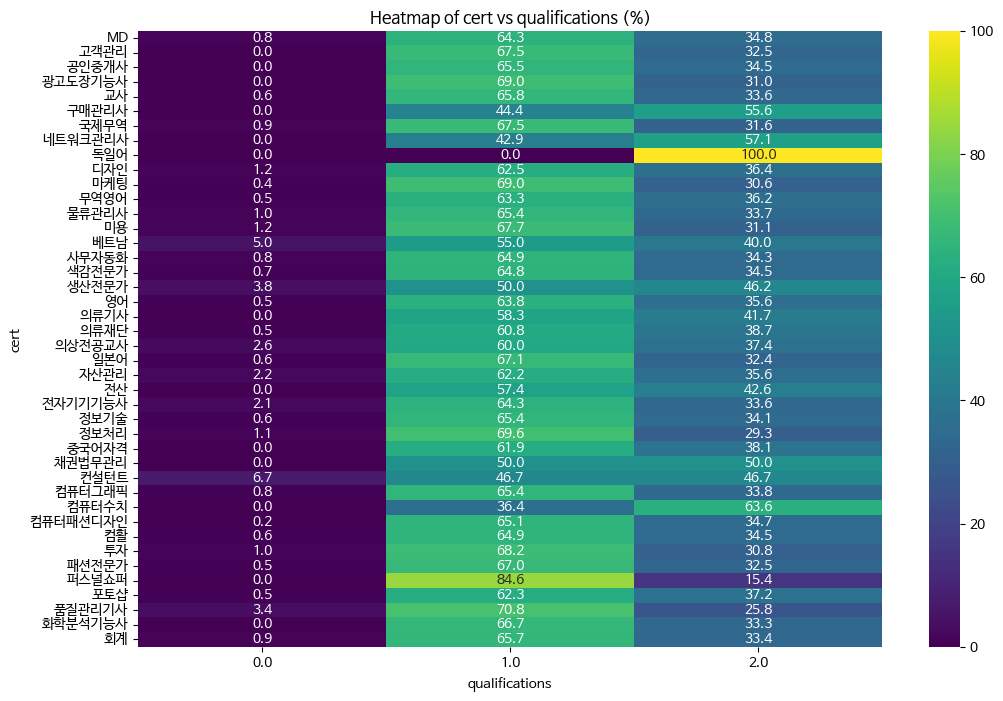

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

# `qualifications`의 리스트를 행으로 확장
melted_data = user_item_eda.qualifications.apply(pd.Series).stack().reset_index(level=1, drop=True).to_frame('qualifications')
melted_data['cert'] = user_item_eda['cert']

# cert 별로 education의 빈도 계산
frequency_table = pd.crosstab(melted_data['cert'], melted_data['qualifications'])

# 각 값이 해당 행의 합계에 대한 비율이 되도록 변환
frequency_percentage = frequency_table.div(frequency_table.sum(axis=1), axis=0) * 100

# 히트맵 시각화 (비율로 표시)
plt.figure(figsize=(12, 8))
# `annot=True`로 설정하여 각 셀에 주석으로 숫자를 표시하고, `fmt='.1f'`로 소수점 한 자리의 백분율 형식으로 나타냅니다.
sns.heatmap(frequency_percentage, annot=True, fmt='.1f', cmap='viridis')
plt.title('Heatmap of cert vs qualifications (%)')
plt.xlabel('qualifications')
plt.ylabel('cert')
plt.show()

## 1) resume의 degree와 recruitment의 education
1. resume와 recruitment '학력' 간 연관성이 있는지 확인해본다.
2. resume의 '학력' 군집화해본다.

In [ ]:
user_item_eda = apply_train.groupby('resume_seq')['recruitment_seq'].apply(list).reset_index(name='recruitment_seq')

In [ ]:
resume['degree'].value_counts()

4    7453
3     463
5     349
2     211
6       6
Name: degree, dtype: int64

In [ ]:
recruitment['education'].value_counts()

3    2862
4    2188
2    1644
6       1
Name: education, dtype: int64

In [ ]:
# map에 필요한 dict를 정의한다.
resume_to_degree_dict = dict(zip(resume['resume_seq'], resume['degree']))
recruitment_to_education_dict = dict(zip(recruitment['recruitment_seq'], recruitment['education']))
# 기존 DataFrame에 'degree'이라는 새로운 열을 추가하고, map의 결과를 할당한다.
user_item_eda['degree'] = user_item_eda['resume_seq'].map(resume_to_degree_dict)

def map_recruitment_seq(seq_list, mapping_dict):
    return [mapping_dict.get(item) for item in seq_list if item in mapping_dict]
# 기존 DataFrame에 'education'라는 새로운 열을 추가하고, map의 결과를 할당한다.
user_item_eda['education'] = user_item_eda['recruitment_seq'].apply(lambda x: map_recruitment_seq(x, recruitment_to_education_dict))
user_item_eda

,resume_seq,recruitment_seq,job_code_seq1,major_task,degree,education
0,U00001,"[R05288, R05210, R06065, R04536]",재료·화학·섬유·의복,"[7, 2, 7, 2]",4,"[4, 3, 4, 3]"
1,U00002,"[R06019, R01730, R01960, R05472, R04588, R0294...",재료·화학·섬유·의복,"[2, 2, 2, 2, 2, 2, 2, 2]",4,"[4, 4, 3, 3, 3, 3, 3, 3]"
2,U00003,"[R01460, R04918, R03301]",재료·화학·섬유·의복,"[2, 2, 2]",4,"[3, 4, 3]"
3,U00004,"[R00004, R02899, R01068, R02003, R02355, R0470...",재료·화학·섬유·의복,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 2, 2, 2, ...",4,"[3, 3, 3, 3, 2, 4, 4, 3, 2, 4, 4, 3, 3, 3, 2, ..."
4,U00005,"[R03914, R00832, R00374]",재료·화학·섬유·의복,"[2, 2, 2]",4,"[4, 3, 4]"
...,...,...,...,...,...,...
8477,U08478,"[R02170, R03939]",재료·화학·섬유·의복,"[2, 2]",4,"[3, 3]"
8478,U08479,"[R04196, R01470, R02988, R03837, R04036, R02787]",재료·화학·섬유·의복,"[2, 2, 2, 2, 2, 2]",3,"[3, 4, 2, 3, 3, 3]"
8479,U08480,"[R00803, R03152]",디자인,"[2, 2]",4,"[2, 4]"
8480,U08481,"[R00225, R05500, R06253]",재료·화학·섬유·의복,"[2, 2, 2]",4,"[3, 3, 2]"


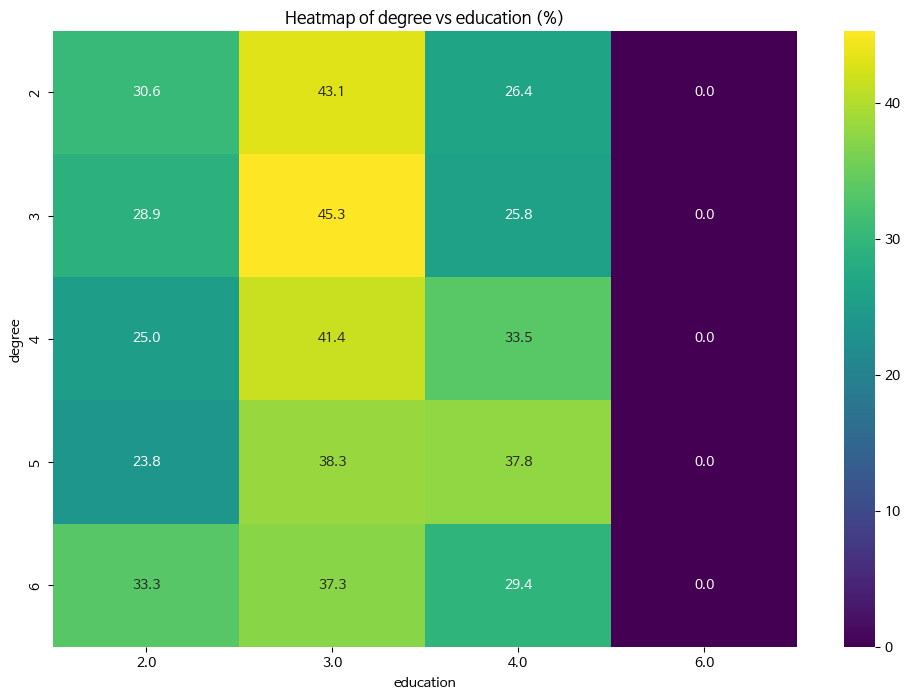

In [ ]:
import warnings
warnings.filterwarnings("ignore")
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# `education`의 리스트를 행으로 확장
melted_data = user_item_eda.education.apply(pd.Series).stack().reset_index(level=1, drop=True).to_frame('education')
melted_data['degree'] = user_item_eda['degree']

# degree 별로 education의 빈도 계산
frequency_table = pd.crosstab(melted_data['degree'], melted_data['education'])

# 각 값이 해당 행의 합계에 대한 비율이 되도록 변환
frequency_percentage = frequency_table.div(frequency_table.sum(axis=1), axis=0) * 100

# 히트맵 시각화 (비율로 표시)
plt.figure(figsize=(12, 8))
# `annot=True`로 설정하여 각 셀에 주석으로 숫자를 표시하고, `fmt='.1f'`로 소수점 한 자리의 백분율 형식으로 나타냅니다.
sns.heatmap(frequency_percentage, annot=True, fmt='.1f', cmap='viridis')
plt.title('Heatmap of degree vs education (%)')
plt.xlabel('education')
plt.ylabel('degree')
plt.show()

## 2) resume의 text_keyword와 recruitment의 check_box_keyword

In [ ]:
recruitment.head(1)

,recruitment_seq,address_seq1,check_box_keyword,education,major_task,qualifications,text_keyword
0,R02264,3.0,2507;2707;2810,4,8,1,NaN


In [ ]:
user_item_matrix = apply_train.groupby(['resume_seq', 'recruitment_seq']).size().unstack(fill_value=0)
user_item_matrix

recruitment_seq,R00001,R00002,R00003,R00004,R00005,R00006,R00007,R00008,R00009,R00010,...,R06686,R06687,R06688,R06689,R06690,R06691,R06692,R06693,R06694,R06695
resume_seq,,,,,,,,,,,,,,,,,,,,,
U00001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
U00002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
U00003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
U00004,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
U00005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U08478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
U08479,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
U08480,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# recruitment['check_box_keyword']

cv = CountVectorizer()
checkbox_matrix = cv.fit_transform(recruitment['check_box_keyword'])
print(type(checkbox_matrix))
print(checkbox_matrix.shape)
# print(checkbox_matrix)

<class 'scipy.sparse._csr.csr_matrix'>
(6695, 61)


In [ ]:
checkbox_cosine_sim = cosine_similarity(checkbox_matrix)
print(checkbox_cosine_sim)
print(checkbox_cosine_sim.shape)

[[1.         0.33333333 0.28867513 ... 0.         0.28867513 0.28867513]
 [0.33333333 1.         0.28867513 ... 0.         0.8660254  0.28867513]
 [0.28867513 0.28867513 1.         ... 0.         0.5        1.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.28867513 0.8660254  0.5        ... 0.         1.         0.5       ]
 [0.28867513 0.28867513 1.         ... 0.         0.5        1.        ]]
(6695, 6695)


In [ ]:
# cosine_similarity() 로 반환된 넘파이 행렬을 영화명을 매핑하여 DataFrame으로 변환
item_sim_df = pd.DataFrame(data=checkbox_cosine_sim, index=user_item_matrix.columns,
                          columns=user_item_matrix.columns)
print(item_sim_df.shape)
item_sim_df.head(3)

(6695, 6695)


recruitment_seq,R00001,R00002,R00003,R00004,R00005,R00006,R00007,R00008,R00009,R00010,...,R06686,R06687,R06688,R06689,R06690,R06691,R06692,R06693,R06694,R06695
recruitment_seq,,,,,,,,,,,,,,,,,,,,,
R00001,1.000000,0.333333,0.288675,0.288675,0.288675,0.288675,0.866025,0.516398,0.000000,0.000000,...,0.471405,0.258199,0.816497,0.666667,0.816497,0.235702,0.288675,0.0,0.288675,0.288675
R00002,0.333333,1.000000,0.288675,0.866025,0.866025,0.866025,0.288675,0.516398,0.408248,0.408248,...,0.235702,0.774597,0.408248,0.333333,0.408248,0.707107,0.866025,0.0,0.866025,0.288675
R00003,0.288675,0.288675,1.000000,0.500000,0.500000,0.500000,0.250000,0.447214,0.530330,0.353553,...,0.816497,0.670820,0.353553,0.577350,0.353553,0.816497,0.500000,0.0,0.500000,1.000000


In [ ]:
def predict_rating(ratings_arr, item_sim_arr ):
    ratings_pred = ratings_arr.dot(item_sim_arr)/ np.array([np.abs(item_sim_arr).sum(axis=1)])
    return ratings_pred

ratings_pred = predict_rating(user_item_matrix.values , item_sim_df.values)
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index= user_item_matrix.index,
                                   columns = user_item_matrix.columns)
ratings_pred_matrix.head(3)

recruitment_seq,R00001,R00002,R00003,R00004,R00005,R00006,R00007,R00008,R00009,R00010,...,R06686,R06687,R06688,R06689,R06690,R06691,R06692,R06693,R06694,R06695
resume_seq,,,,,,,,,,,,,,,,,,,,,
U00001,0.000613,0.000739,0.000609,0.000632,0.000632,0.000632,0.000595,0.000595,0.000620,0.000506,...,0.000716,0.000600,0.000430,0.000422,0.000430,0.000670,0.000632,0.0,0.000632,0.000609
U00002,0.001312,0.001148,0.001401,0.001159,0.001159,0.001159,0.001274,0.001247,0.001082,0.000959,...,0.001370,0.001188,0.001294,0.001309,0.001294,0.001251,0.001159,0.0,0.001159,0.001401
U00003,0.000358,0.000672,0.000481,0.000715,0.000715,0.000715,0.000348,0.000463,0.000649,0.000738,...,0.000444,0.000672,0.000384,0.000385,0.000384,0.000612,0.000715,0.0,0.000715,0.000481


In [ ]:
recruitment.head(1)

,recruitment_seq,address_seq1,check_box_keyword,education,major_task,qualifications,text_keyword
0,R02264,3.0,2507;2707;2810,4,8,1,NaN


In [ ]:
def get_title_from_index(index):
    return recruitment[recruitment.index == index]["title"].values[0]
def get_index_from_title(title):
    return recruitment[recruitment.title == title]["index"].values[0]

recruitment_name = "R02264"
movie_index = get_index_from_title(recruitment_name)
similar_movies = list(enumerate(cosine_sim[movie_index]))

sorted_similar_movies = sorted(similar_movies,key=lambda x:x[1],reverse=True)[1:]

i=0
print(recruitment_name+"와 비슷한 영화 3편은 "+"\n")
for item in sorted_similar_movies:
    print(get_title_from_index(item[0]))
    i=i+1
    if i==3:
        break

NameError: ignored

In [ ]:
resume.isna().sum()

resume_seq           0
degree               0
text_keyword       195
job_code_seq1        0
career_month         0
career_job_code    758
dtype: int64

In [ ]:
resume['text_keyword']

,resume_seq,degree,text_keyword,job_code_seq1,career_month,career_job_code
0,U00606,4,스타일디자이너;우븐디자이너,재료·화학·섬유·의복,67,NaN
1,U00509,2,상품기획;MD;기획;머천다이저;머천다이징,재료·화학·섬유·의복,84,섬유;봉제;가방;의류
2,U02012,5,니트디자인,재료·화학·섬유·의복,121,학교;학원;직원훈련(교육서비스)
3,U04599,4,MD;기획MD,재료·화학·섬유·의복,24,섬유;봉제;가방;의류
4,U07573,4,디자이너;남성복;스포츠웨어;편집디자인;코디네이터;일러스트레이터;VMD;MD,재료·화학·섬유·의복,0,NaN


In [ ]:
! pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 41.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# 한글 처리를 위한 형태소 분석기 라이브러리
from konlpy.tag import Okt
okt = Okt()

# 예시 데이터 프레임 생성
data = {
    'text_keyword': ['스타일디자이너;우븐디자이너', '상품기획;MD;기획;머천다이저;머천다이징', '니트디자인', 'MD;기획MD', '디자이너;남성복;스포츠웨어;편집디자인;코디네이터;일러스트레이터;VMD;MD']
}

df = pd.DataFrame(data)

# 정규화 및 토큰화 함수
def preprocess_text(text):
    # 특수문자 제거
    text = re.sub(r'[^가-힣;]', ' ', text)
    # 키워드 분리
    tokens = text.split(';')
    # 한글 형태소 분석기를 사용하여 토큰화
    tokens = [okt.morphs(token) for token in tokens if token]
    # 2차원 리스트를 1차원으로 평탄화
    tokens = [item for sublist in tokens for item in sublist]
    # 불용어 제거 (불용어 사전이 있다고 가정)
    stopwords = ['불용어1', '불용어2']
    tokens = [word for word in tokens if word not in stopwords]
    return ' '.join(tokens)

# 전처리 적용
df['preprocessed'] = df['text_keyword'].apply(preprocess_text)

# 벡터화 (TF-IDF)
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['preprocessed'])

# 결과 확인
print(df['preprocessed'])
print(tfidf_matrix)

0                           스타일 디자이너 우븐 디자이너
1                상품 기획 기획 머 천 다 이 저 머 천 다 이징
2                                     니트 디자인
3                                         기획
4    디자이너 남성 복 스포츠 웨어 편집디자인 코 디네 이 터 일러스트레이터
Name: preprocessed, dtype: object
  (0, 9)	0.46606680869265926
  (0, 4)	0.7520395333159556
  (0, 7)	0.46606680869265926
  (1, 11)	0.46606680869265926
  (1, 0)	0.7520395333159556
  (1, 6)	0.46606680869265926
  (2, 5)	0.7071067811865475
  (2, 2)	0.7071067811865475
  (3, 0)	1.0
  (4, 12)	0.38775666010579296
  (4, 3)	0.38775666010579296
  (4, 13)	0.38775666010579296
  (4, 10)	0.38775666010579296
  (4, 8)	0.38775666010579296
  (4, 1)	0.38775666010579296
  (4, 4)	0.3128396318588854


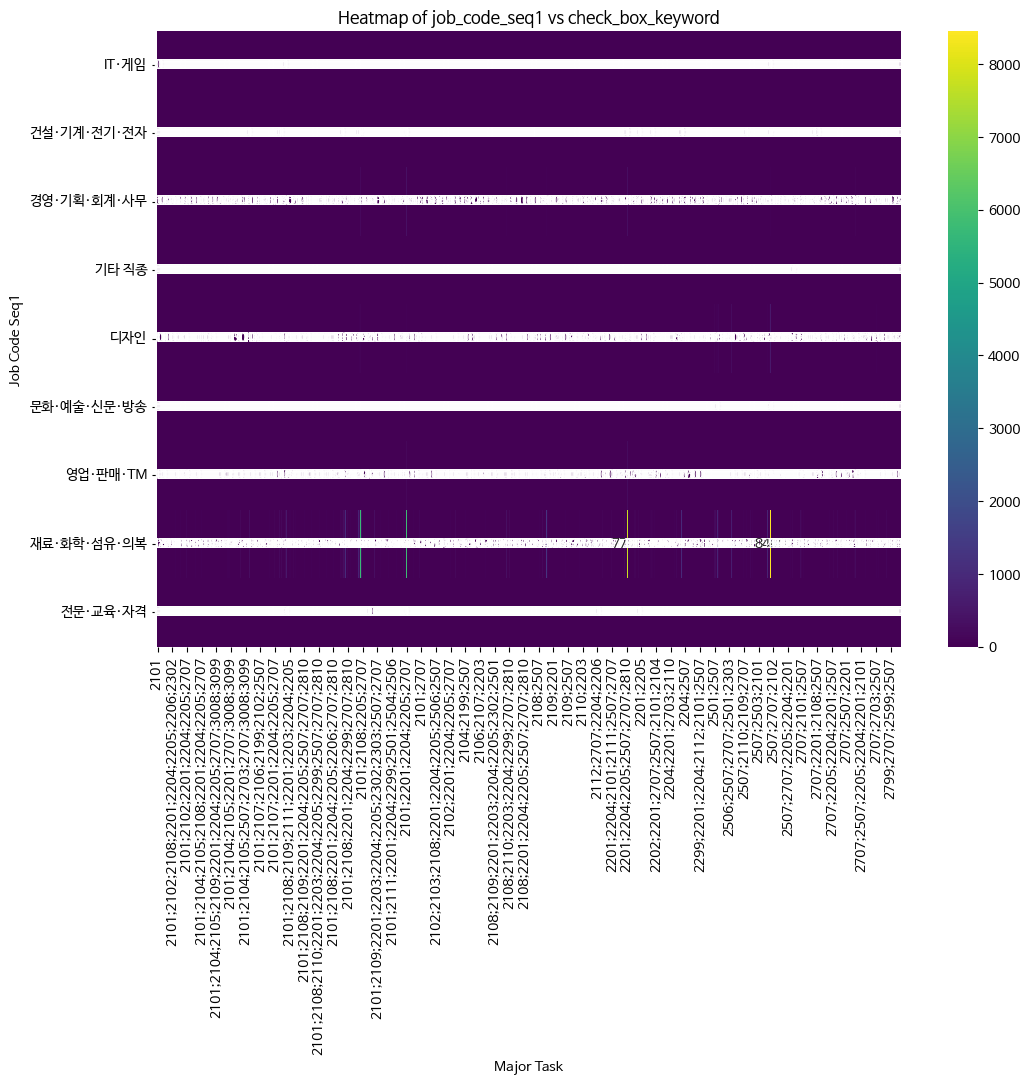

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False
import seaborn as sns

# 가정: `user_item_eda`는 위에서 설명한 구조의 DataFrame입니다.

# Step 1: check_box_key 리스트를 풀어서 새로운 DataFrame 생성
# 이 단계는 `check_box_key`의 리스트를 행으로 확장하는 과정입니다.
melted_data = user_item_eda.check_box_key.apply(pd.Series).stack().reset_index(level=1, drop=True).to_frame('check_box_key')
melted_data['job_code_seq1'] = user_item_eda['job_code_seq1']

# Step 2: job_code_seq1 별로 major_task의 빈도 계산
# `crosstab` 함수를 사용하여 히트맵을 그리기 위한 데이터를 만듭니다.
frequency_table = pd.crosstab(melted_data['job_code_seq1'], melted_data['check_box_key'])

# Step 3: 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(frequency_table, annot=True, fmt='d', cmap='viridis')
plt.title('Heatmap of job_code_seq1 vs check_box_key')
plt.xlabel('Major Task')
plt.ylabel('Job Code Seq1')
plt.show()

## 3) resume의 Job_code_seq1와 recruitment의 major_task
* 📌 resume의 희망직무가 다수(약 86%)가 선택한 것이 아닌 사람들이 지원한 이력서의 major_task 분포 결과 : 완전 무작위!


resume_seq 대신 resume의 job_code_seq1 정보로 채워넣는다.

In [ ]:
# 새로운 데이터 프레임 만들기
user_item_eda = apply_train.groupby('resume_seq')['recruitment_seq'].apply(list).reset_index(name='recruitment_seq')
# map에 필요한 dict를 정의한다.
resume_to_job_dict = dict(zip(resume['resume_seq'], resume['job_code_seq1']))
recruitment_to_job_dict = dict(zip(recruitment['recruitment_seq'], recruitment['major_task']))
# 기존 DataFrame에 'job_code_seq1'이라는 새로운 열을 추가하고, map의 결과를 할당한다.
user_item_eda['job_code_seq1'] = user_item_eda['resume_seq'].map(resume_to_job_dict)
# 기존 DataFrame에 'major_task'라는 새로운 열을 추가하고, map의 결과를 할당한다.

def map_recruitment_seq(seq_list, mapping_dict):
    return [mapping_dict.get(item) for item in seq_list if item in mapping_dict]

user_item_eda['major_task'] = user_item_eda['recruitment_seq'].apply(lambda x: map_recruitment_seq(x, recruitment_to_job_dict))
# resume의 희망직무가 '재료·화학·섬유·의복'이 아닌 사람들이 지원한 이력서의 major_task 분포를 알아보기 -> 필요없는 정보
user_item_eda[user_item_eda['job_code_seq1'] != '재료·화학·섬유·의복']
# major_task의 리스트 중 2를 포함하지 않은 분포 알아보기
user_item_eda

,resume_seq,recruitment_seq,job_code_seq1,major_task
0,U00001,"[R05288, R05210, R06065, R04536]",재료·화학·섬유·의복,"[7, 2, 7, 2]"
1,U00002,"[R06019, R01730, R01960, R05472, R04588, R0294...",재료·화학·섬유·의복,"[2, 2, 2, 2, 2, 2, 2, 2]"
2,U00003,"[R01460, R04918, R03301]",재료·화학·섬유·의복,"[2, 2, 2]"
3,U00004,"[R00004, R02899, R01068, R02003, R02355, R0470...",재료·화학·섬유·의복,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 2, 2, 2, ..."
4,U00005,"[R03914, R00832, R00374]",재료·화학·섬유·의복,"[2, 2, 2]"
...,...,...,...,...
8477,U08478,"[R02170, R03939]",재료·화학·섬유·의복,"[2, 2]"
8478,U08479,"[R04196, R01470, R02988, R03837, R04036, R02787]",재료·화학·섬유·의복,"[2, 2, 2, 2, 2, 2]"
8479,U08480,"[R00803, R03152]",디자인,"[2, 2]"
8480,U08481,"[R00225, R05500, R06253]",재료·화학·섬유·의복,"[2, 2, 2]"


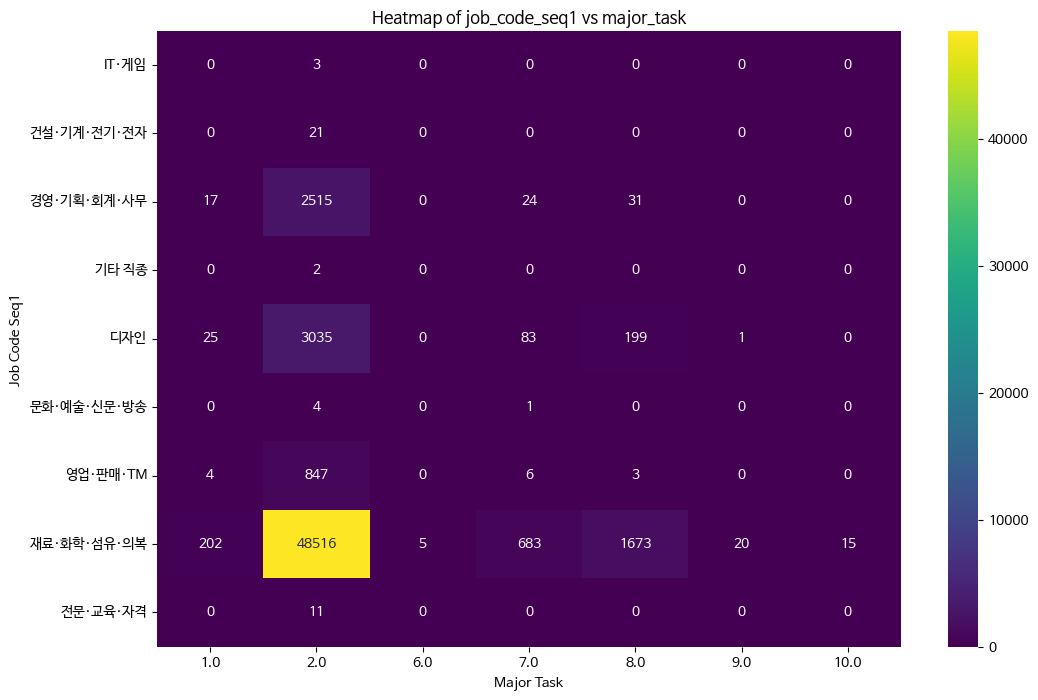

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False
import seaborn as sns

# 가정: `user_item_eda`는 위에서 설명한 구조의 DataFrame입니다.

# Step 1: major_task 리스트를 풀어서 새로운 DataFrame 생성
# 이 단계는 `major_task`의 리스트를 행으로 확장하는 과정입니다.
melted_data = user_item_eda.major_task.apply(pd.Series).stack().reset_index(level=1, drop=True).to_frame('major_task')
melted_data['job_code_seq1'] = user_item_eda['job_code_seq1']

# Step 2: job_code_seq1 별로 major_task의 빈도 계산
# `crosstab` 함수를 사용하여 히트맵을 그리기 위한 데이터를 만듭니다.
frequency_table = pd.crosstab(melted_data['job_code_seq1'], melted_data['major_task'])

# Step 3: 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(frequency_table, annot=True, fmt='d', cmap='viridis')
plt.title('Heatmap of job_code_seq1 vs major_task')
plt.xlabel('Major Task')
plt.ylabel('Job Code Seq1')
plt.show()


8482

## 4) resume의 Job_code_seq1와 recruitment의 major_task

In [ ]:
# 새로운 데이터 프레임 만들기
user_item_eda = apply_train.groupby('resume_seq')['recruitment_seq'].apply(list).reset_index(name='recruitment_seq')
# map에 필요한 dict를 정의한다.
resume_to_job_dict = dict(zip(resume['resume_seq'], resume['job_code_seq1']))
recruitment_to_job_dict = dict(zip(recruitment['recruitment_seq'], recruitment['major_task']))
# 기존 DataFrame에 'job_code_seq1'이라는 새로운 열을 추가하고, map의 결과를 할당한다.
user_item_eda['job_code_seq1'] = user_item_eda['resume_seq'].map(resume_to_job_dict)
# 기존 DataFrame에 'major_task'라는 새로운 열을 추가하고, map의 결과를 할당한다.

def map_recruitment_seq(seq_list, mapping_dict):
    return [mapping_dict.get(item) for item in seq_list if item in mapping_dict]

user_item_eda['major_task'] = user_item_eda['recruitment_seq'].apply(lambda x: map_recruitment_seq(x, recruitment_to_job_dict))
# resume의 희망직무가 '재료·화학·섬유·의복'이 아닌 사람들이 지원한 이력서의 major_task 분포를 알아보기 -> 필요없는 정보
user_item_eda[user_item_eda['job_code_seq1'] != '재료·화학·섬유·의복']
# major_task의 리스트 중 2를 포함하지 않은 분포 알아보기
user_item_eda

---

Hard Voting으로 구현해보기

In [ ]:
from tqdm import tqdm

# 이미 지원한 채용 공고 제외하고 추천
train_recommendations = []

for idx, user in tqdm(enumerate(train_user_item_matrix.index)):
    applied_jobs = set(train_user_item_matrix.loc[user][train_user_item_matrix.loc[user] == 1].index)

    # # 해당 사용자의 추천 점수 (높은 점수부터 정렬)
    # # 코사인 유사도 점수와 자카드 유사도 점수를 결합

    # # 종합 점수 계산
    user_cos= train_user_predicted_scores_cos[idx]
    user_jaccard = train_user_predicted_scores_jaccard[idx]
    item_cos = train_item_predicted_scores_cos[:,idx]
    item_jaccard = train_item_predicted_scores_jaccard[:,idx]

    # 추천할 아이템 정렬
    # sorted_job_indices = combined_scores[idx].argsort()[::-1]
    user_cos = (user_cos).argsort()[::-1]
    recommended_jobs_user_cos = [job for job in train_user_item_matrix.columns[user_cos] if job not in applied_jobs][:5]

    user_jaccard = (user_jaccard).argsort()[::-1]
    recommended_jobs_user_jaccard = [job for job in train_user_item_matrix.columns[user_jaccard] if job not in applied_jobs][:5]

    item_cos = (item_cos).argsort()[::-1]
    recommended_jobs_item_cos = [job for job in train_user_item_matrix.columns[item_cos] if job not in applied_jobs][:5]

    item_jaccard = (item_jaccard).argsort()[::-1]
    recommended_jobs_item_jaccard = [job for job in train_user_item_matrix.columns[item_jaccard] if job not in applied_jobs][:5]

    # 추천 목록에 추가
    # 사용자 코사인 유사도 기반으로 구한 추천 목록
    for job in recommended_jobs_user_cos:
        train_recommendations.append([user, job])

    # 사용자 코사인 유사도 기반으로 구한 추천 목록



8482it [00:24, 342.92it/s]


In [ ]:
recall5(val,val_prediction) # test

0.1269747701013912

In [ ]:
recall5(val,val_prediction) # test

In [ ]:
# 이미 지원한 채용 공고 제외하고 추천
pred_recommendations = []

for idx, user in tqdm(enumerate(pred_user_item_matrix.index)):
    applied_jobs = set(pred_user_item_matrix.loc[user][pred_user_item_matrix.loc[user] == 1].index)

    # # 해당 사용자의 추천 점수 (높은 점수부터 정렬)
    # # 코사인 유사도 점수와 자카드 유사도 점수를 결합

    # # 종합 점수 계산

    user_scores = (pred_user_predicted_scores_cos[idx] * 1 + pred_user_predicted_scores_jaccard[idx] * 1.2) * 2
    item_scores = pred_item_predicted_scores_cos[:,idx] * 1 + pred_item_predicted_scores_jaccard[:,idx] * 1.2
    combined_scores = user_scores + item_scores

    # 추천할 아이템 정렬
    # sorted_job_indices = combined_scores[idx].argsort()[::-1]
    sorted_job_indices = (combined_scores).argsort()[::-1]
    recommended_jobs = [job for job in pred_user_item_matrix.columns[sorted_job_indices] if job not in applied_jobs][:5]

    # 추천 목록에 추가
    for job in recommended_jobs:
        pred_recommendations.append([user, job])

8482it [00:08, 1009.91it/s]


In [ ]:
top_recommendations = pd.DataFrame(pred_recommendations, columns=['resume_seq', 'recruitment_seq'])
top_recommendations.to_csv('./rladbwjd.csv', index=False)

In [ ]:
top_recommendations = pd.DataFrame(pred_recommendations, columns=['resume_seq', 'recruitment_seq'])
top_recommendations.to_csv('./cosine_jaccard_user_ratio_1_1.csv', index=False)

In [ ]:
recall5(val,val_prediction) # test

0.121669417590191

In [ ]:
recall5(val,val_prediction)  # 1

0.12190521103513323

In [ ]:
item_weight = 1

# 이미 지원한 채용 공고 제외하고 추천
pred_recommendations = []

for idx, user in tqdm(enumerate(pred_user_item_matrix.index)):
    applied_jobs = set(pred_user_item_matrix.loc[user][pred_user_item_matrix.loc[user] == 1].index)

    # # 해당 사용자의 추천 점수 (높은 점수부터 정렬)
    # # 코사인 유사도 점수와 자카드 유사도 점수를 결합

    # # 종합 점수 계산
    # user_scores = pred_user_predicted_scores_jaccard[idx]
    item_scores = pred_item_predicted_scores_jaccard[:,idx] * item_weight
    # combined_scores = user_scores + item_scores

    # 추천할 아이템 정렬
    # sorted_job_indices = combined_scores[idx].argsort()[::-1]
    sorted_job_indices = (item_scores).argsort()[::-1]
    recommended_jobs = [job for job in pred_user_item_matrix.columns[sorted_job_indices] if job not in applied_jobs][:5]

    # 추천 목록에 추가
    for job in recommended_jobs:
        pred_recommendations.append([user, job])

0it [00:00, ?it/s]

In [ ]:
top_recommendations = pd.DataFrame(pred_recommendations, columns=['resume_seq', 'recruitment_seq'])
top_recommendations.to_csv('./data/jaccard_item.csv', index=False)

In [ ]:
val_prediction = pd.DataFrame(train_recommendations, columns=['resume_seq', 'recruitment_seq'])

In [ ]:
recall5(val,val_prediction) # test

0.1269747701013912

In [ ]:
recall5(val,val_prediction)

0.12721056354633342

In [ ]:
recall5(val,val_prediction)
# alpha = 1  # cosine + user
# beta = 0  # cosine + item
# gamma = 0.98  # jaccard + user
# delta = 0  # jaccard + item

0.12909691110587126

1. 0.12756425371374674
    * alpha = 1  # cosine + user
    * beta = 1.02  # cosine + item
    * gamma = 0.98  # jaccard + user
    * delta = 1  # jaccard + item
2. 0.12732846026880454
    * alpha = 0.98  # cosine + user
    * beta = 1  # cosine + item
    * gamma = 0.99  # jaccard + user  1
    * delta = 0.69  # jaccard + item 0.7

In [ ]:
alpha = 1  # cosine + user
beta = 1.03  # jaccard + user
gamma = 0.5  # cosine + item
delta = 0.5  # jaccard + item

# 이미 지원한 채용 공고 제외하고 추천
pred_recommendations = []

for idx, user in tqdm(enumerate(pred_user_item_matrix.index)):
    applied_jobs = set(pred_user_item_matrix.loc[user][pred_user_item_matrix.loc[user] == 1].index)

    # # 해당 사용자의 추천 점수 (높은 점수부터 정렬)
    # # 코사인 유사도 점수와 자카드 유사도 점수를 결합

    # # 종합 점수 계산
    user_scores = pred_user_predicted_scores_cos[idx] * alpha + pred_user_predicted_scores_jaccard[idx] * beta
    item_scores = pred_item_predicted_scores_cos[:,idx] * gamma + pred_item_predicted_scores_jaccard[:,idx] * delta
    combined_scores = user_scores + item_scores

    # 추천할 아이템 정렬
    # sorted_job_indices = combined_scores[idx].argsort()[::-1]
    sorted_job_indices = (combined_scores).argsort()[::-1]
    recommended_jobs = [job for job in pred_user_item_matrix.columns[sorted_job_indices] if job not in applied_jobs][:5]

    # 추천 목록에 추가
    for job in recommended_jobs:
        pred_recommendations.append([user, job])

8482it [00:08, 980.93it/s] 


In [ ]:
top_recommendations = pd.DataFrame(pred_recommendations, columns=['resume_seq', 'recruitment_seq'])
# top_recommendations.to_csv('./cosine_jaccard_item_user_alpha_1_beta_1.02_gamma_0.98_delta_0.9.csv', index=False)

In [ ]:
top_recommendations

,resume_seq,recruitment_seq
0,U00001,R01528
1,U00001,R03811
2,U00001,R06276
3,U00001,R00165
4,U00001,R03037
...,...,...
42405,U08482,R04602
42406,U08482,R00473
42407,U08482,R00712
42408,U08482,R04021


In [ ]:
top = train_recommendations + pred_recommendations
top_recommendations = pd.DataFrame(top, columns=['resume_seq', 'recruitment_seq'])

top_recommendations.to_csv('./cosine_jaccard_item_user_alpha_1_beta_1.1_gamma_0.5_delta_0.3.csv', index=False)

# 3. 행렬분해

In [ ]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

# Label encoding the resume and recruitment identifiers to create a matrix
# resume_encoder = LabelEncoder()
# recruitment_encoder = LabelEncoder()

# # Fit the encoders and transform the data to encoded integers
# apply_train['resume_seq_encoded'] = resume_encoder.fit_transform(apply_train['resume_seq'])
# apply_train['recruitment_seq_encoded'] = recruitment_encoder.fit_transform(apply_train['recruitment_seq'])

# Create the interaction matrix
apply_train = pd.read_csv('./apply_train.csv')
interaction_matrix = apply_train.groupby(['resume_seq', 'recruitment_seq']).size().unstack(fill_value=0)

# Flatten the matrix to get the dataframe for training with only 1's and 0's
interaction_matrix_flat = interaction_matrix.applymap(lambda x: 1 if x > 0 else 0)

# Let's generate synthetic features
# For simplicity, we'll create random features, in a real-world scenario these should be meaningful features extracted from resumes and job postings
num_synthetic_features = 10
num_resumes = interaction_matrix_flat.shape[0]
num_jobs = interaction_matrix_flat.shape[1]

# Generate random features for resumes and jobs
np.random.seed(0)  # For reproducibility
resume_features = np.random.rand(num_resumes, num_synthetic_features)
job_features = np.random.rand(num_jobs, num_synthetic_features)

# Now we need to create a training dataset where each sample is a combination of a resume's features and a job's features
# and the target is whether the resume applied to the job or not
train_data = []
train_labels = []

for resume_idx in range(num_resumes):
    for job_idx in range(num_jobs):
        # Combine features of resumes and jobs
        combined_features = np.hstack((resume_features[resume_idx], job_features[job_idx]))
        train_data.append(combined_features)
        # The target is whether this resume has applied to this job
        train_labels.append(interaction_matrix_flat.iloc[resume_idx, job_idx])

# Convert to numpy arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=0)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the neural network model
model = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid because we're doing binary classification
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=256, verbose=1, validation_split=0.1)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)

accuracy


NameError: ignored